### Example for creating synthetic time lapse ERT measurement for watershed

1. Following the workflow code
2. Make it a function that we can do the forward modeling for the whole water year
3. See the apparent resistivity

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from mpl_toolkits.axes_grid1 import make_axes_locatable


# For Jupyter notebooks, use the current working directory
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()
# Add the parent directory (OPEN_ERT) to the path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import using the structure as you originally intended
from watershed_geophysics.model_output.modflow_output import MODFLOWWaterContent
from watershed_geophysics.core.interpolation import ProfileInterpolator,create_surface_lines
from watershed_geophysics.core.mesh_utils import MeshCreator
from watershed_geophysics.petrophysics.resistivity_models import water_content_to_resistivity
from watershed_geophysics.forward.ert_forward import ERTForwardModeling

In [2]:
output_dir = "results/TL_measurements"
os.makedirs(output_dir, exist_ok=True)

In [3]:
print("Step 1: Set up the ERT profiles like in the workflow example.")

data_dir = "data/"
modflow_dir = os.path.join(data_dir, "modflow")

# Load domain information from files
# (Replace with your actual file paths)
idomain = np.loadtxt(os.path.join(data_dir, "id.txt"))
top = np.loadtxt(os.path.join(data_dir, "top.txt"))
porosity = np.load(os.path.join(data_dir, "Porosity.npy"))

# Define profile endpoints
point1 = [115, 70]  # [col, row]
point2 = [95, 180]  # [col, row]

# Initialize profile interpolator
interpolator = ProfileInterpolator(
    point1=point1,
    point2=point2,
    surface_data=top,
    origin_x=569156.2983333333,
    origin_y=4842444.17,
    pixel_width=1.0,
    pixel_height=-1.0
)

# Interpolate porosity to profile
porosity_profile = interpolator.interpolate_3d_data(porosity)



# Load structure layers
bot = np.load(os.path.join(data_dir, "bot.npy"))

# Process layers to get structure
structure = interpolator.interpolate_layer_data([top] + bot.tolist())

# Create surface lines
# Indicate the layer for the structure regolith, fractured bedrock and fresh bedrock
top_idx=int(0)
mid_idx=int(4)
bot_idx=int(12)
surface, line1, line2 = create_surface_lines(
    L_profile=interpolator.L_profile,
    structure=structure,
    top_idx=0,
    mid_idx=4,
    bot_idx=12
)

# Create mesh
mesh_creator = MeshCreator(quality=32)
mesh, geom = mesh_creator.create_from_layers(
    surface=surface,
    layers=[line1, line2],
    bottom_depth= np.min(line2[:,1])-10 #50.0
)

# Save mesh
mesh.save(os.path.join(output_dir, "mesh.bms"))



ID1 = porosity_profile.copy()
ID1[:mid_idx] = 0 #regolith
ID1[mid_idx:bot_idx] = 3 # fractured bedrock
ID1[bot_idx:] = 2 # fresh bedrock

# Get mesh centers and markers
mesh_centers = np.array(mesh.cellCenters())
mesh_markers = np.array(mesh.cellMarkers())

# Interpolate porosity to mesh
porosity_mesh = interpolator.interpolate_to_mesh(
    property_values=porosity_profile,
    depth_values=structure,
    mesh_x=mesh_centers[:, 0],
    mesh_y=mesh_centers[:, 1],
    mesh_markers=mesh_markers,
    ID=ID1, # Use ID1 to indicate the layers for interpolation
    layer_markers = [0,3,2],

)
# load water content
Water_Content = np.load(os.path.join(data_dir, "Watercontent.npy"))

Step 1: Set up the ERT profiles like in the workflow example.


In [9]:
os.makedirs("results/TL_measurements/synwcmodel", exist_ok=True)
os.makedirs("results/TL_measurements/synresmodel", exist_ok=True)


for i in range(len(Water_Content)):
    water_content = Water_Content[i]
    # Interpolate water content to profile
    water_content_profile = interpolator.interpolate_3d_data(water_content)

    # Interpolate water content to mesh
    wc_mesh = interpolator.interpolate_to_mesh(
        property_values=water_content_profile,
        depth_values=structure,
        mesh_x=mesh_centers[:, 0],
        mesh_y=mesh_centers[:, 1],
        mesh_markers=mesh_markers,
        ID=ID1,  # Use ID1 to indicate the layers for interpolation
        layer_markers=[0, 3, 2],
    )

    # Convert to resistivity using petrophysical model
    marker_labels = [0, 3, 2]  # top, mid, bottom layers
    rho_sat = [100, 500, 2400]  # Saturated resistivity for each layer (example values)
    n_val = [2.2, 1.8, 2.5]  # Cementation exponent for each layer (example values)
    # sigma_s was originally defined as [1/500, 0, 0] but here we use [0.002, 0, 0]
    sigma_s = [0.002, 0, 0]

    res_models = np.zeros_like(wc_mesh)

    mask = (mesh_markers == marker_labels[0])
    top_res = water_content_to_resistivity(
        wc_mesh[mask],
        float(rho_sat[0]),
        float(n_val[0]),
        porosity_mesh[mask],
        sigma_s[0]
    )
    res_models[mask] = top_res

    mask = (mesh_markers == marker_labels[1])
    mid_res = water_content_to_resistivity(
        wc_mesh[mask],
        float(rho_sat[1]),
        float(n_val[1]),
        porosity_mesh[mask],
        sigma_s[1]
    )
    res_models[mask] = mid_res

    mask = (mesh_markers == marker_labels[2])
    bot_res = water_content_to_resistivity(
        wc_mesh[mask],
        float(rho_sat[2]),
        float(n_val[2]),
        porosity_mesh[mask],
        sigma_s[2]
    )
    res_models[mask] = bot_res

    np.save(os.path.join(output_dir, "synwcmodel/synwcmodel" + str(i) ), wc_mesh)
    np.save(os.path.join(output_dir, "synresmodel/synresmodel" + str(i) ), res_models)




In [ ]:
## non parallel computing version 
# os.makedirs("results/TL_measurements/appres", exist_ok=True)

# for i in range(2): 
#     # Create synthetic data

#     res_model = np.load(os.path.join(output_dir, "synresmodel/synresmodel" + str(i) ))
#     xpos = np.linspace(15,15+72 - 1,72)
#     ypos = np.interp(xpos,interpolator.L_profile,interpolator.surface_profile)
#     pos = np.hstack((xpos.reshape(-1,1),ypos.reshape(-1,1)))

#     schemeert = ert.createData(elecs=pos,schemeName='wa')

#     # do the forward modeling
#     mesh.setCellMarkers(np.ones(mesh.cellCount())*2)
#     grid = pg.meshtools.appendTriangleBoundary(mesh, marker=1,
#                                             xbound=100, ybound=100)

#     fwd_operator = ERTForwardModeling(mesh=grid, data=schemeert)

#     synth_data = schemeert.copy()
#     fob = ert.ERTModelling()
#     fob.setData(schemeert)
#     fob.setMesh(grid)
#     dr = fob.response(res_model)

#     dr *= 1. + pg.randn(dr.size()) * 0.05
#     ert_manager = ert.ERTManager(synth_data)
#     synth_data['rhoa'] = dr
#     synth_data['err'] = ert_manager.estimateError(synth_data, absoluteUError=0.0, relativeError=0.05)

#     synth_data.save(os.path.join(output_dir, "appres/synthetic_data"+str(i)+".dat"))

In [ ]:
## parallel computing version 

import os
import numpy as np
import pygimli as pg
from pygimli.physics import ert

from joblib import Parallel, delayed

def process_timestep(i, output_dir, mesh_array, interpolator_L_profile, interpolator_surface_profile):
    """Process a single timestep for synthetic data generation"""
    try:
        # Load the resistivity model for this timestep
        res_model = np.load(os.path.join(output_dir, "synresmodel/synresmodel" + str(i) + ".npy"))
        
        # Create electrode positions
        xpos = np.linspace(15, 15+72-1, 72)
        ypos = np.interp(xpos, interpolator_L_profile, interpolator_surface_profile)
        pos = np.hstack((xpos.reshape(-1,1), ypos.reshape(-1,1)))
        
        # Create ERT data scheme
        schemeert = ert.createData(elecs=pos, schemeName='wa')
        
        mesh = pg.load(os.path.join(output_dir, "mesh.bms"))
        # Set cell markers
        mesh.setCellMarkers(np.ones(mesh.cellCount())*2)
        
        # Create boundary mesh
        grid = pg.meshtools.appendTriangleBoundary(mesh, marker=1, xbound=100, ybound=100)
        
        # Set up forward operator
        fwd_operator = ert.ERTModelling()
        fwd_operator.setData(schemeert)
        fwd_operator.setMesh(grid)
        
        # Forward modeling
        synth_data = schemeert.copy()
        dr = fwd_operator.response(res_model)
        
        # Add 5% random noise
        dr *= 1. + pg.randn(dr.size()) * 0.05
        
        # Set up ERT manager and save data
        ert_manager = ert.ERTManager(synth_data)
        synth_data['rhoa'] = dr
        synth_data['err'] = ert_manager.estimateError(synth_data, absoluteUError=0.0, relativeError=0.05)
        
        # Save synthetic data
        synth_data.save(os.path.join(output_dir, "appres/synthetic_data"+str(i)+".dat"))
        
        return i, True, None  # Success
    except Exception as e:
        return i, False, str(e)  # Return error information




In [ ]:
# Create output directories if they don't exist
os.makedirs(os.path.join(output_dir, "appres"), exist_ok=True)


# Extract necessary data from interpolator to pass to workers
interpolator_L_profile = interpolator.L_profile.copy()
interpolator_surface_profile = interpolator.surface_profile.copy()

# Process in parallel
results = Parallel(n_jobs=2, verbose=10)(
    delayed(process_timestep)(
        i, 
        output_dir, 
        None,  # We'll reload the mesh from file instead of passing it
        interpolator_L_profile,
        interpolator_surface_profile
    ) for i in range(Water_Content.shape[0])
)

# Check results
success_count = sum(1 for _, success, _ in results if success)
print(f"Successfully processed {success_count} out of {len(results)} timesteps")

# Print any errors
for i, success, error in results:
    if not success:
        print(f"Error in timestep {i}: {error}")


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1ca12046cd0>)

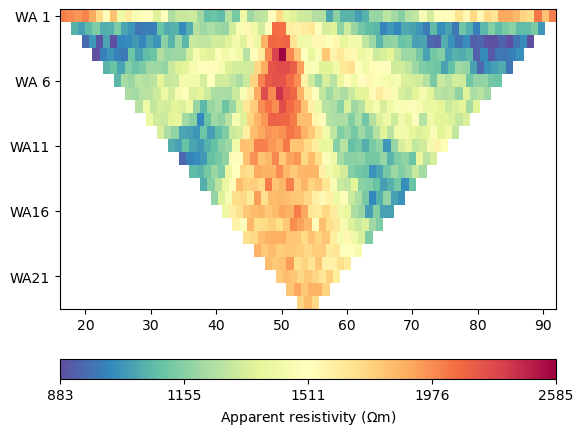

In [ ]:
### example to load and show the synthetic data
syn_data = pg.load(os.path.join(output_dir, "appres/synthetic_data"+str(1)+".dat"))
ert.show(syn_data)

In [4]:
#load all synthetic data and plot them
all_syn_data = []
for i in range(Water_Content.shape[0]):
    try:
        syn_data = pg.load(os.path.join(output_dir, "appres/synthetic_data" + str(i) + ".dat"))
        all_syn_data.append(np.array(syn_data['rhoa']))
    except Exception as e:
        print(f"Error loading synthetic data for timestep {i}: {e}")

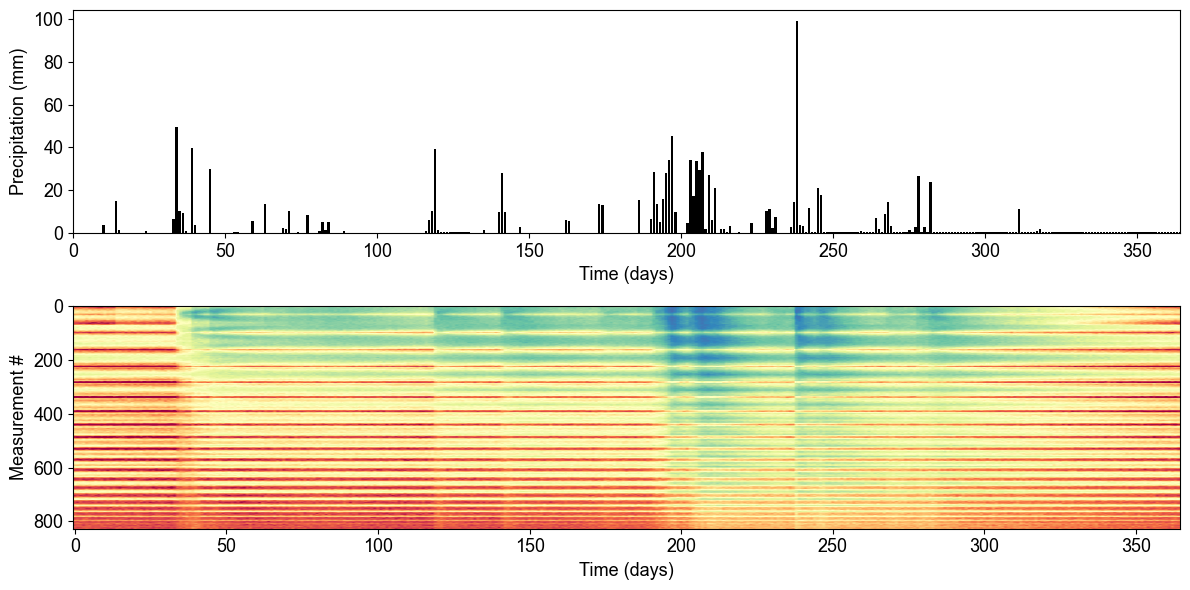

In [7]:
## plot the apparent resitivity
import pandas as pd
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"


rng = pd.date_range(start="09/01/2011", end="08/30/2012", freq="D")
precip = np.load(os.path.join(data_dir, "precip.npy"))
syn_data_array = np.array(all_syn_data)
syn_data_array.shape



plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.bar(np.arange(365),precip,color='k')
plt.xlim([0,364])
plt.ylabel('Precipitation (mm)')
plt.xlabel('Time (days)')
plt.subplot(212)
plt.imshow(syn_data_array.T, aspect='auto', cmap=pg.utils.cMap('rhoa'), vmin=200, vmax=2000)
plt.ylabel('Measurement #')
plt.xlabel('Time (days)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "apparent_resistivity.tiff"), dpi=300)

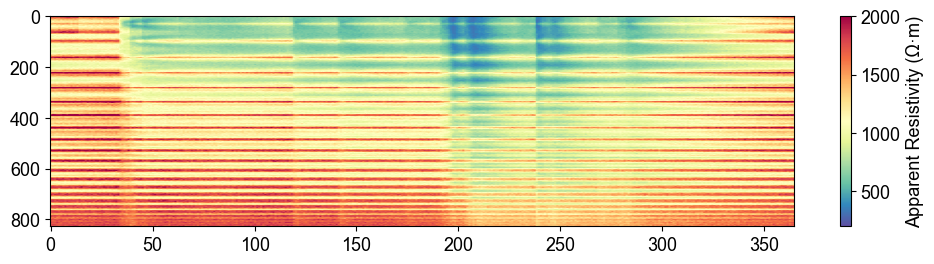

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.imshow(syn_data_array.T, aspect='auto', cmap=pg.utils.cMap('rhoa'), vmin=200, vmax=2000)
plt.colorbar(label='Apparent Resistivity (Ω·m)')

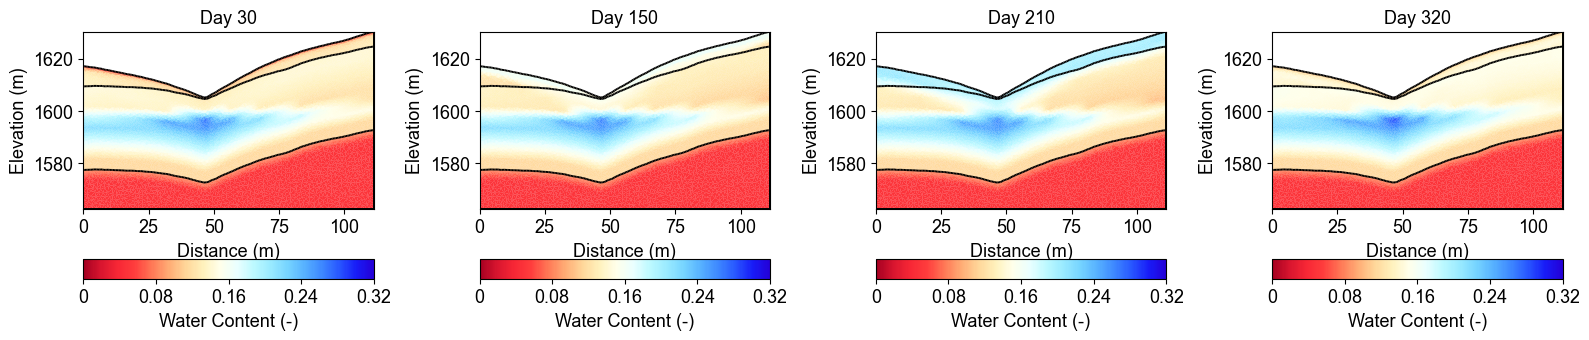

In [10]:
## Showing the water content model for the differnent timesteps
fig, axes = plt.subplots(1, 4, figsize=(16, 14))

from palettable.lightbartlein.diverging import BlueDarkRed18_18_r
fixed_cmap = BlueDarkRed18_18_r.mpl_colormap
ax1 = axes[0]
wc25 = np.load(os.path.join(output_dir, "synwcmodel/synwcmodel30.npy"  ))
cbar1 = pg.show(mesh, wc25, ax=ax1, cMap=fixed_cmap, logScale=False, 
              cMin=0.0, cMax=0.32, label='Water Content (-)',xlabel='Distance (m)', ylabel='Elevation (m)')
ax1.set_title("Day 30")


ax1 = axes[1]
wc150= np.load(os.path.join(output_dir, "synwcmodel/synwcmodel150.npy"  ))
cbar1 = pg.show(mesh, wc150, ax=ax1, cMap=fixed_cmap, logScale=False, 
              cMin=0.0, cMax=0.32, label='Water Content (-)',xlabel='Distance (m)', ylabel='Elevation (m)')
ax1.set_title("Day 150")


ax1 = axes[2]
wc210= np.load(os.path.join(output_dir, "synwcmodel/synwcmodel210.npy"  ))
cbar1 = pg.show(mesh, wc210, ax=ax1, cMap=fixed_cmap, logScale=False, 
              cMin=0.0, cMax=0.32, label='Water Content (-)',xlabel='Distance (m)', ylabel='Elevation (m)')
ax1.set_title("Day 210")


ax1 = axes[3]
wc280= np.load(os.path.join(output_dir, "synwcmodel/synwcmodel320.npy"  ))
cbar1 = pg.show(mesh, wc280, ax=ax1, cMap=fixed_cmap, logScale=False, 
              cMin=0.0, cMax=0.32, label='Water Content (-)',xlabel='Distance (m)', ylabel='Elevation (m)')
ax1.set_title("Day 320")

fig.tight_layout()
plt.savefig(os.path.join(output_dir, "water_content_model.tiff"), dpi=300)

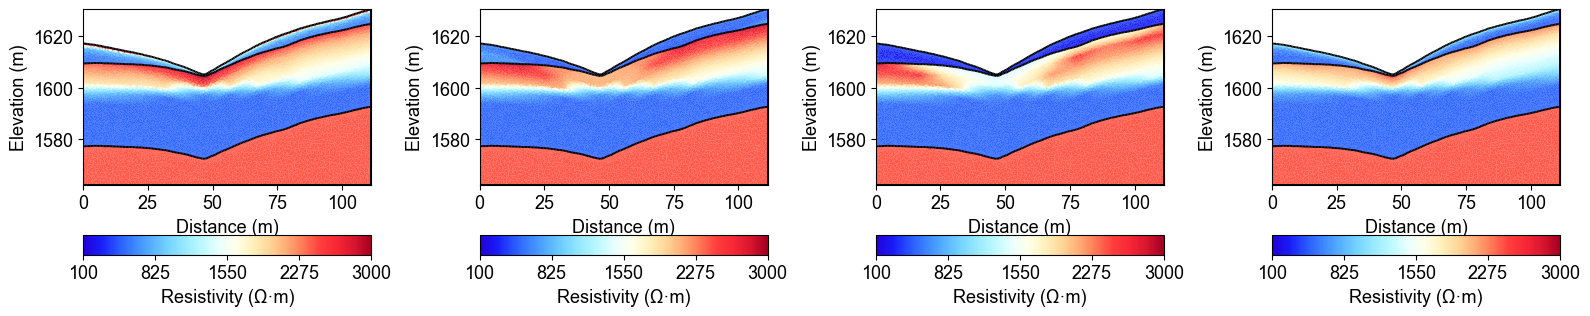

In [13]:
## Showing the water content model for the differnent timesteps
fig, axes = plt.subplots(1, 4, figsize=(16, 14))

from palettable.lightbartlein.diverging import BlueDarkRed18_18
fixed_cmap = BlueDarkRed18_18.mpl_colormap
ax1 = axes[0]
wc30 = np.load(os.path.join(output_dir, "synresmodel/synresmodel30.npy"  ))
cbar1 = pg.show(mesh, wc30, ax=ax1, cMap=fixed_cmap, logScale=False, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=100, cMax=3000)



ax1 = axes[1]
wc150= np.load(os.path.join(output_dir, "synresmodel/synresmodel150.npy"  ))
cbar1 = pg.show(mesh, wc150, ax=ax1, cMap=fixed_cmap, logScale=False, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=100, cMax=3000)



ax1 = axes[2]
wc210= np.load(os.path.join(output_dir, "synresmodel/synresmodel210.npy"  ))
cbar1 = pg.show(mesh, wc210, ax=ax1, cMap=fixed_cmap, 
              logScale=False, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=100, cMax=3000)


ax1 = axes[3]
wc280= np.load(os.path.join(output_dir, "synresmodel/synresmodel320.npy"  ))
cbar1 = pg.show(mesh, wc280, ax=ax1, cMap=fixed_cmap, logScale=False, showColorBar=True,
        xlabel="Distance (m)", ylabel="Elevation (m)",
        label='Resistivity (Ω·m)', cMin=100, cMax=3000)


fig.tight_layout()
plt.savefig(os.path.join(output_dir, "resistivity_model.tiff"), dpi=300)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import io

# Import your color map
from palettable.lightbartlein.diverging import BlueDarkRed18_18_r
fixed_cmap = BlueDarkRed18_18_r.mpl_colormap

# Create a list to store the frames
frames = []

# Set the DPI for consistent figure size
dpi = 100

# Create frames and store them in memory
for i in range(365):
    # Print progress update
    if i % 10 == 0:
        print(f"Processing frame {i} of 365")
        
    # Set up new figure for each frame - reduced height to eliminate empty space
    fig = plt.figure(figsize=[8, 2.2])
    
    # Use more of the figure space
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    ax = fig.add_subplot(1, 1, 1)
    
    # Load data
    moi = np.load(os.path.join(output_dir, f"synwcmodel/synwcmodel{i}.npy"))
    
    # Plot the data
    ax, cbar = pg.show(mesh, moi, pad=0.3, orientation="vertical", 
                     cMap=fixed_cmap, cMin=0.00, cMax=0.32,
                     xlabel="", ylabel="",  # Remove labels to save space
                     label='Water content', ax=ax)
    
    # Style adjustments
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    # Add day counter with better positioning and visibility
    # Use transAxes to position the text in a consistent location
    ax.text(0.1, 0.1, f'Day: {i}', transform=ax.transAxes,
            fontsize=12, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3))
    
    # Add compact axis labels
    ax.text(0.5, 0.02, 'Distance (m)', transform=ax.transAxes, 
            ha='center', fontsize=8)
    ax.text(0.02, 0.5, 'Elevation (m)', transform=ax.transAxes, 
            va='center', rotation=90, fontsize=8)
    
    # Save to buffer instead of file
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
    plt.close(fig)  # Close the figure
    
    # Convert buffer to image and append to frames
    buf.seek(0)
    img = Image.open(buf)
    frames.append(img.copy())  # Copy the image to ensure it stays in memory
    buf.close()

print("All frames processed!")

# Save as GIF
gif_path = os.path.join(output_dir, "WCanimation.gif")
# The first frame's duration will be longer (500ms) to show initial state
durations = [500] + [100] * (len(frames) - 1)  # 100ms per frame after the first

# Save the GIF with optimized settings
frames[0].save(
    gif_path,
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=durations,
    loop=0,  # 0 means loop forever
    optimize=True
)

print(f"GIF saved successfully to {gif_path}")

Processing frame 0 of 365
Processing frame 10 of 365
Processing frame 20 of 365
Processing frame 30 of 365
Processing frame 40 of 365
Processing frame 50 of 365
Processing frame 60 of 365
Processing frame 70 of 365
Processing frame 80 of 365
Processing frame 90 of 365
Processing frame 100 of 365
Processing frame 110 of 365
Processing frame 120 of 365
Processing frame 130 of 365
Processing frame 140 of 365
Processing frame 150 of 365
Processing frame 160 of 365
Processing frame 170 of 365
Processing frame 180 of 365
Processing frame 190 of 365
Processing frame 200 of 365
Processing frame 210 of 365
Processing frame 220 of 365
Processing frame 230 of 365
Processing frame 240 of 365
Processing frame 250 of 365
Processing frame 260 of 365
Processing frame 270 of 365
Processing frame 280 of 365
Processing frame 290 of 365
Processing frame 300 of 365
Processing frame 310 of 365
Processing frame 320 of 365
Processing frame 330 of 365
Processing frame 340 of 365
Processing frame 350 of 365
Pro